In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, \
    RobustScaler, FunctionTransformer
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn import set_config

In [2]:
np.random.seed(42)
set_config(display='diagram')

plt.rcParams['figure.figsize'] = (12, 8)
sns.set_theme(style="whitegrid")

In [3]:
trainDf = pd.read_csv("data/train.csv")
testDf = pd.read_csv("data/test.csv")

In [4]:
# Remove outliers
trainDf.drop(
    trainDf[(trainDf["GrLivArea"] > 4000) & (trainDf["SalePrice"] < 700000)].index
);

In [5]:
baselineFeatures = [
    '1stFlrSF',
    '2ndFlrSF',
    'BsmtFinSF1', 
    'BsmtFinSF2',
    'BsmtUnfSF',
    'OverallQual',
    'GarageCars', 
    'OverallCond', 
    'Neighborhood', 
    'MSSubClass', 
    'LotShape',
    'LandSlope',
    'BsmtCond',
    'BsmtQual',
]

X = trainDf[baselineFeatures]
Y = trainDf['SalePrice']

In [6]:
X_train, X_validation, y_train, y_validation = train_test_split(X, Y, test_size=0.3, random_state=42)

In [7]:
subclassCategories = [20, 30, 40, 45, 50, 60, 70, 75, 80, 85, 90, 120, 150, 160, 180, 190]
basementFinishCategories = ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']

In [8]:
# Build feature transformer

logTransformer = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

basementCondTransformer = Pipeline([
    ('basement_condition_impute', SimpleImputer(strategy="constant", fill_value='None')),
    ('basement_condition_onehot', OneHotEncoder()),
])

basementAreaTransformer = Pipeline([
    ('basement_area_impute', SimpleImputer(strategy="constant", fill_value=0)),
    ('basement_area_log', logTransformer),
])

featureTransformer = ColumnTransformer([
        ('garage_cars_impute', SimpleImputer(strategy="constant", fill_value=0), ['GarageCars']),
        ('basement_area_transformer', basementAreaTransformer, ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF']),
        ('neighborhood_onehot', OneHotEncoder(), ['Neighborhood']),
        ('subclass_onehot', OneHotEncoder(categories=[subclassCategories]), ['MSSubClass']),
        ('lot_shape_onehot', OneHotEncoder(), ['LotShape']),
        ('land_slope_onehot', OneHotEncoder(), ['LandSlope']),
        ('basement_condition_transformer', basementCondTransformer, ['BsmtCond', 'BsmtQual']),
    ],
    remainder='passthrough'
)

In [9]:
linRegrPipeline = Pipeline([
    ("preprocessing", featureTransformer),
    ("regression", TransformedTargetRegressor(regressor=LinearRegression(), func=np.log1p, inverse_func=np.expm1)),
])

linRegrPipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('garage_cars_impute',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['GarageCars']),
                                                 ('basement_area_transformer',
                                                  Pipeline(steps=[('basement_area_impute',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('basement_area_log',
                                                                   FunctionTransformer(func=<ufunc 'log1...
                                                  OneHotEncoder(),
                                                  ['LandSlope']),
                                                 ('basement_condition_transformer',
                                                  Pipeline(steps=[('basement_condition_impute',
                                                                   SimpleImputer(fill_value='None',
                                                                                 strategy='constant')),
                                                                  ('basement_condition_onehot',
                                                                   OneHotEncoder())]),
                                                  ['BsmtCond', 'BsmtQual'])])),
                ('regression',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=LinearRegression()))])

In [10]:
linRegrPipeline.fit(X_train, y_train)

y_train_predicted = linRegrPipeline.predict(X_train)
y_validation_predicted_lr = linRegrPipeline.predict(X_validation)

print('[Train] Mean Squared Error: %.2f' % mean_squared_error(y_train, y_train_predicted))
print('[Train] Coefficient of Determination: %.2f' % r2_score(y_train, y_train_predicted))
print('[Test] Mean Squared Error: %.2f' % mean_squared_error(y_validation, y_validation_predicted_lr))
print('[Test] Coefficient of Determination: %.2f' % r2_score(y_validation, y_validation_predicted_lr))

[Train] Mean Squared Error: 958048035.85
[Train] Coefficient of Determination: 0.84
[Test] Mean Squared Error: 625030423.35
[Test] Coefficient of Determination: 0.91


In [11]:
lassoPipeline = Pipeline([
    ('preprocessing', featureTransformer),
    ('lasso', TransformedTargetRegressor(regressor=LassoCV(), func=np.log1p, inverse_func=np.expm1)),
])

lassoPipeline.fit(X_train, y_train)

y_train_predicted = lassoPipeline.predict(X_train)
y_validation_predicted_lasso = lassoPipeline.predict(X_validation)

print('[Train] Mean Squared Error: %.2f' % mean_squared_error(y_train, y_train_predicted))
print('[Train] Coefficient of Determination: %.2f' % r2_score(y_train, y_train_predicted))
print('[Test] Mean Squared Error: %.2f' % mean_squared_error(y_validation, y_validation_predicted_lasso))
print('[Test] Coefficient of Determination: %.2f' % r2_score(y_validation, y_validation_predicted_lasso))

[Train] Mean Squared Error: 3939485551.35
[Train] Coefficient of Determination: 0.35
[Test] Mean Squared Error: 1399212992.27
[Test] Coefficient of Determination: 0.80


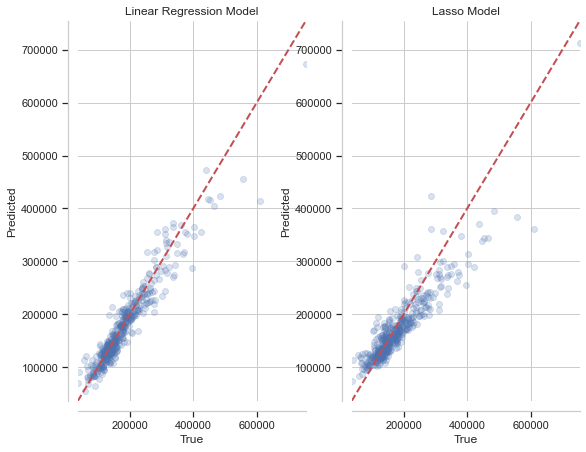

In [12]:
def plot_regression_results(ax, y_true, y_pred, title):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')
    
    ax.set_title(title)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9, 7))

plot_regression_results(
    ax0, 
    y_true=y_validation, 
    y_pred=y_validation_predicted_lr, 
    title="Linear Regression Model"
)

plot_regression_results(
    ax1, 
    y_true=y_validation, 
    y_pred=y_validation_predicted_lasso, 
    title="Lasso Model"
)

In [13]:
x_test = testDf[baselineFeatures]
y_test_predicted = linRegrPipeline.predict(x_test)

submissionDf = pd.DataFrame({
    'Id': testDf['Id'],
    'SalePrice': y_test_predicted,
})

submissionDf.to_csv('./data/submission_linear_regression.csv', index=False)